# Notes about simulation:

**Running info**
- 2250 simulations
- week queue

**EA params**
- 160 generations
- 250 individuals
- 0.1 mutation rate
- 0.5 crossover rate

**Parameter search space**
- beta_0,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
- minimums = [ -4,   -2, -2, -2, -2,   -2, -2, -2, -2,   -2, -2,     -2, -2, -2, -2,    -2, -2, -2, -2]
- maximums = [4.5,    4,  4,  4,  4,    4,  4,  4,  4,    4,  4,     4,   4,  4,  4,     4,  4,  4,  4]

**Mean of Mean Square Error of the top 2.5% of Individuals** 
- 1404.57196018


$$MAP3K_I = MAP3K_t-MAP3K$$
$$MAP2K_I = MAP2K_t-MAP2K$$
$$MAPK_I = MAPK_t-MAPK$$


$$\dfrac{dMAP3K}{dt} = \dfrac{ s}{1+\dfrac{MAPK}{\beta}} \cdot \dfrac{k1\cdot MAP3K_I}{K_1 + MAP3K_I} - \dfrac{k2\cdot MAP3K}{K_2+MAP3K}$$

$$\dfrac{dMAP2K}{dt} = \dfrac{k3\cdot MAP3K\cdot MAP2K_I}{K_3 + MAP2K_I} - \dfrac{k4\cdot MAP2K}{K_4+MAP2K}$$

$$\dfrac{dMAPK}{dt} = \dfrac{k5\cdot MAP2K\cdot MAPK_I}{K_5 + MAPK_I} - \dfrac{k6\cdot MAPK}{K_6+MAPK}$$


# Import packages and set settings

In [3]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
import pandas as pd
from scipy.integrate import odeint
import os

In [4]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

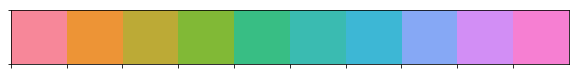

In [5]:
sns.palplot(sns.husl_palette(10, l=.7))
palette_husl = sns.husl_palette(10, l=.7)
# palette_husl.as_hex()

# Load data to fit to

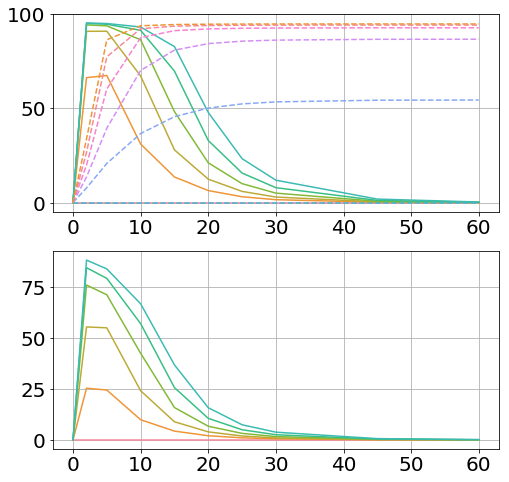

In [49]:
# wt_folder = '../data/MAPK activation/WT'
# t100a_folder = '../data/MAPK activation/T100A'

# def load_csv_data(folder):
#     data = []
#     for csv in pathlib.Path(folder).glob('*.csv'):
#         f_data = pd.read_csv(csv)
#         time = f_data['Time'].tolist()
#         f_data=f_data.set_index('Time')
#         f_data = f_data.mean(axis=1)
#         f_data = f_data.tolist()
#         data.append(f_data)
#     return time, data

# mapk_time, mapk_wt_data = load_csv_data(wt_folder)
# mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)

# scorefxn_data = [mapk_wt_data, mapk_t100a_data]
def open_synth_data(filename):
    scorefxn_arr = pickle.load(open(filename, 'rb'))
    scorefxn_time, scorefxn_data = scorefxn_arr 

    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(8,8))
    # use_consistent_colors = ['b','g']
    for strain,dash in zip(scorefxn_data[:2], ['-','--']):
        for idx, exp in enumerate(strain):
            ax1.plot(scorefxn_time, exp, dash, markersize=10)#,color=color_palette[idx])
    #     print(len(strain))
    ax1.grid()
#     plt.show()
    for strain,dash in zip(scorefxn_data[2:4], ['-','--']):
        for idx, exp in enumerate(strain):
            ax2.plot(scorefxn_time, exp, dash, markersize=10)#,color=color_palette[idx])
    #     print(len(strain))
    ax2.grid()
    plt.show()
    return scorefxn_time, scorefxn_data


filename = 'C:/Users/sksuzuki/Desktop/killdevil/to/190103_synthdata_wt_t100a_map2k_b0_a3_1D_on_off.pickled'
scorefxn_time, scorefxn_data = open_synth_data(filename)

# Supporting Functions

In [42]:
# def scorefxn1(scorefxn_time, scorefxn_data, inits, params_constants,
#               learned_params, time, plot_bool):
#     mse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#     for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
#         params_constants = params_constants[:-1]+[sig]

#         # WT simulation
#         data = simulate_wt_experiment(inits, params_constants, arr_params_IP, time)
#         active = (data[:,2] + data[:,3])/params_constants[2]*100
#         # get index of time points closest
#         idx_closest_time_points = []
#         for each_time in scorefxn_time:
#             closest_idx = min(range(len(time)),
#                               key = lambda i: abs(time[i] - each_time))
#             idx_closest_time_points.append(closest_idx)
#         # use indexes of time points to get data points to score against
#         _scorefxn_data_active = active[[idx_closest_time_points]]
#         error_active = ((MAPK_wt_data - _scorefxn_data_active)**2).mean()
#         mse_total += error_active

#         # T100A simulation
#         data = simulate_t100a_experiment(inits, params_constants, arr_params_IP, time)
#         active = (data[:,2] + data[:,3])/params_constants[2]*100
#         idx_closest_time_points = []
#         for each_time in scorefxn_time:
#             closest_idx = min(range(len(time)),
#                               key = lambda i: abs(time[i] - each_time))
#             idx_closest_time_points.append(closest_idx)
#         _scorefxn_data_active = active[[idx_closest_time_points]]
#         error_active = ((MAPK_t100a_data - _scorefxn_data_active)**2).mean()
#         mse_total += error_active
#     return mse_total


# def scorefxn_helper(individual):
#     # just a helper function that pulls all of scorefxn1 dependencies together
#     # note the (), <--using single optimization in DEAP for now
#     # scorefxn1 is taking care of the multiple optimizations for now
#     return scorefxn1(mapk_time, scorefxn_data, inits, params_constants, individual, time, False),

def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44
    return molecules/(Na*cell_volume*10**-15)*1000000

def gather_simulated_data(folder, gen, runs):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*0.05)
    plt_top = round((runs-empty_data)*0.01)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
    new_params = np.asarray(new_params)
    new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
    # top_params = []
    # for idx in idx_top:
    #     top_params.append(params_from_file[idx][100])

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses

# def plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
#                         params_constants, initals, time):
#     plt.clf()
#     fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


#     # plot 1
#     title_text = 'Gen ' + str(gen) + ' fit to WT'
#     ax1.set_title(title_text, fontsize=20)
#     ax1.set_xlabel('Time', fontsize=20)
#     plt.rc('xtick', labelsize=20) 
#     plt.rc('ytick', labelsize=20)
#     color_palette = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']
    
#     for idx, wt_data in enumerate(mapk_wt_data):
#         ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
        
#     # plot 2
#     title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=20)
    
#     for idx, t100a_data in enumerate(mapk_t100a_data):
#         ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette[idx])

#     # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
#     # plot evolutionary algorithm data on plots 1 and 2:
#     unstable_wt = 0
#     unstable_t100a = 0
#     for idx in idx_top[:plt_top]:
#         learned_params = params_from_file[idx][gen]
#         for idx, sig in enumerate(params_constants[-1]):
#             params_c = params_constants[:-1]+[sig]
#             data = simulate_wt_experiment(initals, params_c, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax1.plot(time, active, color=color_palette[idx])
#             else:
#                 unstable_wt += 1
#             data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax2.plot(time, active, color=color_palette[idx])
#             else:
#                 unstable_t100a += 1
#     print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
#     print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.show()
    
    #plot3 
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    pal = sns.color_palette("Greys", 20)[10:]
#     c_pal = sns.set_palette(pal)
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
#     pal = sns.set_palette(pal)
    sns.set_palette(pal)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    plt.show()
    

def plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    pal = sns.set_palette(colors)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('MSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('MSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# One step delay

## A3

### Functions

In [63]:
def b3_a3_1D_X(initals,t,params_constants,params_synth,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, s = params_constants
    k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8 = params_synth
    beta_3, alpha_3, a3o = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+X/beta_3)) * (((k1+(alpha_3*MAPK)*a3o)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, params_constants, params_synth, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    print(params_constants)
    print(params_synth)
    print(learned_params)
    odes = odeint(b3_a3_1D_X, inits, time, args=(params_constants, params_synth, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, params_synth, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8 = params_synth
    beta_3, alpha_3, a3o = learned_params

    params_synth = k1, k3, k5, 0, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8
    learned_params = beta_3, 0 , a3o

    #solve odes:
    odes = odeint(b3_a3_1D_X, inits, time, args=(params_constants, params_synth, learned_params))

    return odes

In [52]:
def plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


    # plot 1
    title_text = 'Gen ' + str(gen) + ' fit to WT'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    color_palette = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']
    
    for idx, wt_data in enumerate(mapk_wt_data):
        ax1.plot(time, wt_data, 'o', markersize=10, color=color_palette[idx])
        
    # plot 2
    title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=20)
    
    for idx, t100a_data in enumerate(mapk_t100a_data):
        ax2.plot(time, t100a_data, '^', mew=2, markersize=10, color=color_palette[idx])

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, params_synth,learned_params, time)
            active = data[:,2]/params_constants[2]*100
#             print(active)
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette[idx])
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, params_synth,learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette[idx])
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()

### Inputs

In [57]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/190107_synthdata_b0_1D_a3-_test/'

gen = 100
runs = 1100

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

# MAP3K_t = molarity_conversion(1170)
# MAP2K_t = molarity_conversion(2282)
# MAPK_t = molarity_conversion(5984)
# X_t = 1

MAPK_t = 100
MAP2K_t = 100
MAP3K_t = 100
X_t = 100

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-','+fb 3K','on/off fb' ]

minimums = [-3,-4, 0]

maximums = [ -2, 1, 1]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, s] 
params_synth = [#0.0029588800827973685, 0.012112138800907163#,
                0.00023481531506867081, 311.65437579294962, 20.216367659054534, 0.10971722617866624,
                129.70369943155902, 108.97732361327013, 6634.3132502604594, 0.00010039834663900335,
                0.75204204522899465, 41.564680292557291,11.570923836091632,0.00010081207185935826,
                883.50887257730767, 22.888457311116095,1138.5591403190585, 7437.8949813729732]

params_synth_all = [0.0029588800827973685, 0.012112138800907163, 1,
                0.00023481531506867081, 311.65437579294962, 20.216367659054534, 0.10971722617866624,
                129.70369943155902, 108.97732361327013, 6634.3132502604594, 0.00010039834663900335,
                0.75204204522899465, 41.564680292557291,11.570923836091632,0.00010081207185935826,
                883.50887257730767, 22.888457311116095,1138.5591403190585, 7437.8949813729732]
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)


In [46]:
def make_conversion_matrix(number_of_params):
    # want easily savable matrix to hold this info
    # interp boolean, interp range (min,max), power boolean, power number (y)
    arr_IandP = np.zeros((5,number_of_params))
    # Set all interp booleans to 1 - everything is going to be interpreted
    arr_IandP[0,:] = 1
    # Set all power booleans to 1 - everything is in the form of powers
    arr_IandP[3,:] = 1
    # Set all power numbers to 10 - everything has a base of 10
    arr_IandP[4,:] = 10
    # arr_IandP[4,-1] =
    # Set minimums and maximums for all parameters. Parameters are in the following order:
    # beta_0,    k1, k3, k5, k7, k9,    k2, k4, k6, k8, k10,       K_1, K_3, K_5, K_7, K_9,    K_2, K_4, K_6, K_8, K_10
    # [0.0029588800827973685, #0.012112138800907163#,
    # 0.00023481531506867081, 311.65437579294962, 20.216367659054534, 0.10971722617866624,
    # 129.70369943155902, 108.97732361327013, 6634.3132502604594, 0.00010039834663900335,
    # 0.75204204522899465, 41.564680292557291,11.570923836091632,0.00010081207185935826,
    # 883.50887257730767, 22.888457311116095,1138.5591403190585, 7437.8949813729732]
    minimums = [-3,-4, 0]

    maximums = [-2, 1, 1]

    for i in range(len(minimums)):
        arr_IandP[1,i] = minimums[i] #interp_range_min
        arr_IandP[2,i] = maximums[i] #interp_range_max

    return arr_IandP

arr_conversion_matrix = make_conversion_matrix(3)

def convert_individual(ea_individual, conversion_matrix,
                    number_of_params, number_of_fbs):
    # copy and get len of individual
    arr_params_conv = np.zeros(number_of_params)#np.copy(arr_parameters)
    len_ind = len(ea_individual)

    # Interp:
    for idx in np.nonzero(conversion_matrix[0])[0][:-number_of_fbs]:
        ea_val = ea_individual[idx]
        r_min = conversion_matrix[1][idx]
        r_max = conversion_matrix[2][idx]
        arr_params_conv[idx] = np.interp(ea_val, (0,1), (r_min, r_max))

    # Exponentiate:
    for idx in np.nonzero(conversion_matrix[3])[0][:-number_of_fbs]:
        ea_val = arr_params_conv[idx]
        base_val = conversion_matrix[4][idx]
        arr_params_conv[idx] = np.power(base_val, ea_val)
#     print(ea_individual[number_of_params:])
    arr_params_conv[number_of_params-1:] = [np.round(ea_val) for ea_val in ea_individual[number_of_params-1:]]
    return arr_params_conv

convert_individual([0.001,.23442,.93042], arr_conversion_matrix,
                                     3, 1)

array([0.00100231, 0.00148628, 1.        ])

### Gather simulated data

In [47]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a3_1D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.iloc[:,:2].apply(np.log10)
df_top_params_log[labelnames[2]]= df_top_params.iloc[:,2]
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 6614.2233381663345
Mean MSE of top 5%: 6615.095116402481


### Plot

[100, 100, 100, 100, 0]
[0.0002348153150686708, 311.6543757929496, 20.216367659054534, 0.10971722617866624, 129.70369943155902, 108.97732361327013, 6634.313250260459, 0.00010039834663900335, 0.7520420452289946, 41.56468029255729, 11.570923836091632, 0.00010081207185935826, 883.5088725773077, 22.888457311116095, 1138.5591403190585, 7437.894981372973]
[0.0029588800827973685, 0.012112138800907163, 1]
[100, 100, 100, 100, 150000]
[0.0002348153150686708, 311.6543757929496, 20.216367659054534, 0.10971722617866624, 129.70369943155902, 108.97732361327013, 6634.313250260459, 0.00010039834663900335, 0.7520420452289946, 41.56468029255729, 11.570923836091632, 0.00010081207185935826, 883.5088725773077, 22.888457311116095, 1138.5591403190585, 7437.894981372973]
[0.0029588800827973685, 0.012112138800907163, 1]
[100, 100, 100, 100, 250000]
[0.0002348153150686708, 311.6543757929496, 20.216367659054534, 0.10971722617866624, 129.70369943155902, 108.97732361327013, 6634.313250260459, 0.0001003983466390033

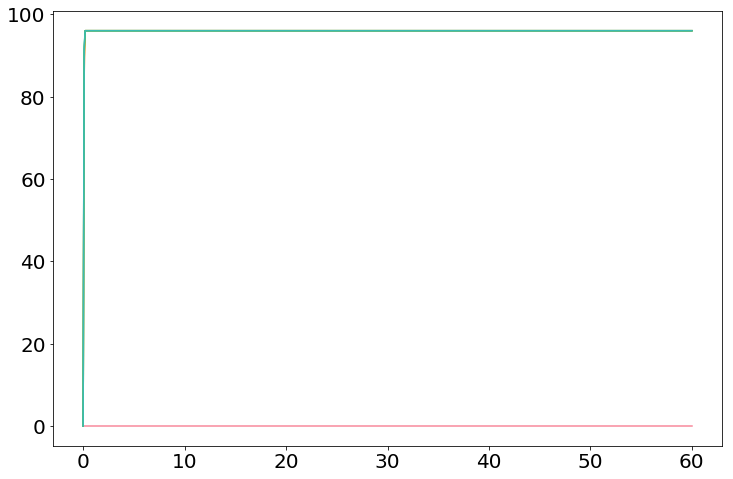

In [69]:
for idx, sig in enumerate(s):
    params_constants = params_constants[:-1]+[sig]
    test_ode = simulate_wt_experiment(initals, params_constants, params_synth_all[3:],params_synth_all[:3], time)
    test_active = test_ode[:,2]/params_constants[2]*100
    plt.plot(time, test_active)

# of unstable WT experiments: 0 of 66
# of unstable T100A experiments: 0 of 66


<Figure size 864x576 with 0 Axes>

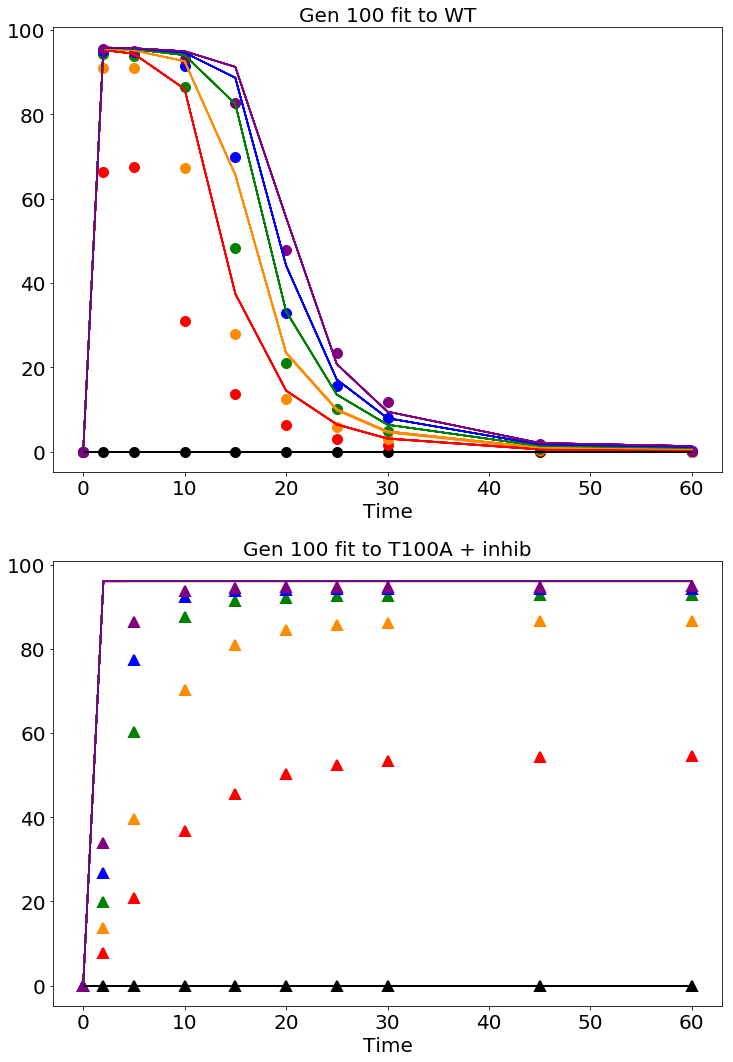

In [53]:
plt_param_behaviors(scorefxn_data[0], scorefxn_data[1], gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, scorefxn_time)

<Figure size 864x576 with 0 Axes>

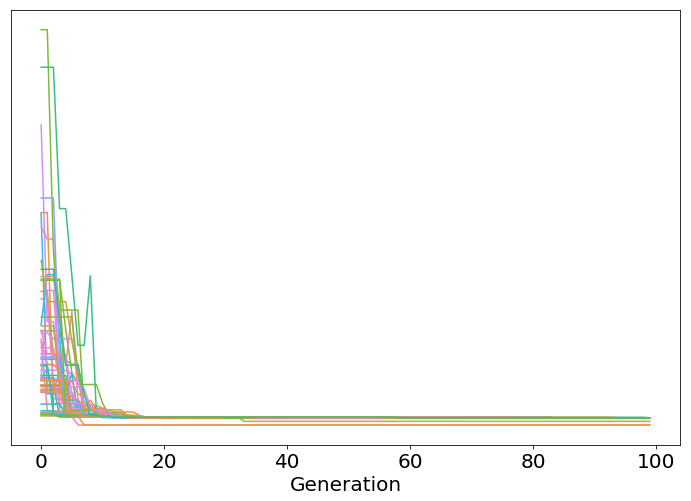

In [38]:
plt_mses_gen(gen,mse)

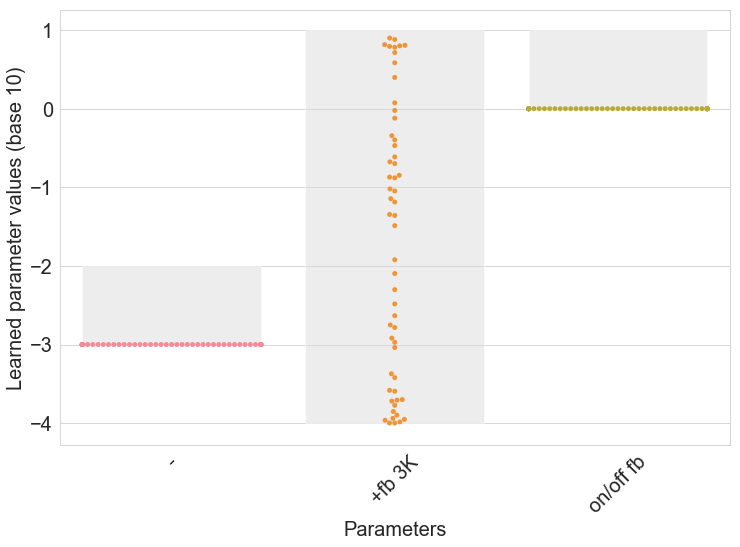

In [39]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa
 

# colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:4]+ rocket[::-1][:4]
colors = palette_husl
plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

### Lab meeting

#### individ

In [ ]:
colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

color_palette = sns.color_palette(colors)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
for i, params in enumerate(top_params[17:18]):#17:18
#     beta_1, beta_2, alpha, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, kn, kc = params
#     params = beta_1, beta_2, 0, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, 0, kc
    #plot real data:
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
        data = odeint(b3_a3_1D_X, initals, time, args=(params_constants[:-1]+[signal], params))
        active = data[:,2]/params_constants[2]*100
        ax1.plot(time, active, label=str(int(signal/1000))+'mM KCl', color=color_palette[idx])

#     plt.title(f'Param set {i}')
    ax1.set_title('One simulation fit to WT data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('% ppHog1')
#     plt.show()
    ax1.set_xlim(0,32)
    ax1.set_ylim(0,105)
    ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/wt_individ.png",dpi=150, bbox_inches='tight')
    plt.clf()


In [ ]:
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))

for i, params in enumerate(top_params[17:18]):#17:18
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        plt.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
#         plt.plot(time, data[:,4], dashes=[2, 2], label=str(signal)+' X')
        data = simulate_t100a_experiment(initals, params_constants[:-1]+[signal], params, time)
        active = data[:,2]/params_constants[2]*100
        plt.plot(time, active, label=str(int(signal/1000))+'mM KCl', dashes= [4,2], color=color_palette[idx])
#         plt.plot(time, data[:,3], label=str(signal)+' MAPKn')
#     plt.title(f'Param set {i}')
    ax2.set_title('One simulation fit to Hog1 T100A + Inhib data')
    ax2.set_xlim(0,32)
    ax2.set_ylim(0,105)
    ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('% ppHog1')
#     plt.ylim(0,100)
#     plt.show()
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/t100a_individ.png",dpi=150, bbox_inches='tight')

In [ ]:
fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
for i in range(0,gen+1,5):
    #plot3 
    # sns.color_palette(palette_husl)
#     pal = sns.color_palette("Greys", 20)[10:]
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
    pal = sns.set_palette(pal)
    for idx in idx_top[17:18]:
        ax3.semilogy([x for x in range(i)], mse[idx][:i], color='black')
    #     ax3.plot([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_xlim(0,505)
    ax3.set_ylim(800,20000)
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    # ax3.yaxis.set_minor_locator(locmin)
    # ax3.yaxis.set_minor_formatter(mticker.NullFormatter())
#     plt.show()
#     plt.ioff()
plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mse_individ.png",dpi=150)
plt.show()

In [ ]:
labelnames = ['-fb', '+fb',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 'K7',
              'K2', 'K4', 'K6', 'K8'
                ]

rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e','#3c3c3c'] + rocket[::-1][:4]*4
param_col = sns.set_palette(colors)
all_top_params = [params_from_file[x] for x in idx_top]
    
# for i in range(0,gen+1,5):
plt.clf()
top_params = [all_top_params[x][gen] for x in range(100)]
df_top_params = pd.DataFrame(top_params[17:18])
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

fig, (ax4) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))


ax4.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
ax4 = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M, color=param_col, size=10)
ax4.set_xticklabels(labelnames,rotation=45)
#     ax.set_yscale("log")
#     ax.set_ylim(0.00001,100000)
#     ax4.set_xticks(locs)
#     plt.xticklabels(labelnames, fontsize=18, rotation=90)
ax4.set_xlabel('Parameters', fontsize=20)
ax4.set_ylabel('Learned parameter values (base 10)', fontsize=20)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax4.yaxis.grid(True)
# plt.show()
plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/param_individ.png",dpi=150)
#     plt.ioff()

#### gifs

In [ ]:
colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

pal = sns.color_palette(colors)
sns.palplot(pal)

In [ ]:
dt = 0.1
steps = 300
time = np.linspace(0,dt*steps,steps)

import warnings
warnings.filterwarnings(action='once')

for i in range(0,gen+1,5):
    plt.clf()


    # with sns.axes_style("whitegrid"):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

    pal = sns.color_palette(colors)

    # plot 1
    title_text = 'Gen ' + str(i) + ' fit to WT'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    # color_palette = sns.color_palette("rocket", 6)[::-1]


    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
    # unstable_wt = 0
    # unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][i]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=pal[idx])
    #         else:
    #             unstable_wt += 1
    #             unstable_t100a += 1
    # print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    # print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    for idx, wt_data in enumerate(mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=pal[idx])

    ax1.set_xlim(0,32)
    ax1.set_ylim(0,105)
    ax1.yaxis.grid(True)
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/fits/wt/"+str(i)+".png",dpi=150)
    plt.ioff()


In [ ]:
warnings.filterwarnings(action='once')

for i in range(0,gen+1,5):
    plt.clf()


    # with sns.axes_style("whitegrid"):
    fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
        # with sns.axes_style("whitegrid"):
    colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

    pal = sns.color_palette(colors)

    # plot 2
    title_text = 'Gen ' + str(i) +  ' fit to T100A + inhib'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=20)

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
    # unstable_wt = 0
    # unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][i]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
    #             unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=pal[idx])
    #         else:
    #             unstable_t100a += 1


    for idx, t100a_data in enumerate(mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=pal[idx])
    ax2.set_xlim(0,32)
    ax2.set_ylim(0,105)
    ax2.yaxis.grid(True)
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/fits/t100a/"+str(i)+".png",dpi=150)
    plt.ioff()

In [ ]:
for i in range(0,gen+1,5):
    plt.clf()
    fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    #plot3 
    # sns.color_palette(palette_husl)
    pal = sns.color_palette("Greys", 20)[10:]
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
    pal = sns.set_palette(pal)
    for idx in idx_top:
        ax3.semilogy([x for x in range(i)], mse[idx][:i])
    #     ax3.plot([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_xlim(0,505)
    ax3.set_ylim(800,20000)
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    # ax3.yaxis.set_minor_locator(locmin)
    # ax3.yaxis.set_minor_formatter(mticker.NullFormatter())
#     plt.show()
#     plt.ioff()
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mse_gen/"+str(i)+".png",dpi=150)
plt.clf()

In [ ]:
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e','#3c3c3c'] + rocket[::-1][:4]*4
param_col = sns.set_palette(colors)
all_top_params = [params_from_file[x] for x in idx_top]
    
for i in range(0,gen+1,5):
    plt.clf()
    top_params = [all_top_params[x][i] for x in range(100)]
    df_top_params = pd.DataFrame(top_params)
    df_top_params.columns = labelnames
    df_top_params_log = df_top_params.apply(np.log10)
    df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

    fig, (ax4) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    

    ax4.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
    ax4 = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M, color=param_col)
    ax4.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
    ax4.set_xlabel('Parameters', fontsize=20)
    ax4.set_ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax4.yaxis.grid(True)
#     plt.show()
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/params_ranges/"+str(i)+".png",dpi=150)
    plt.ioff()

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

In [ ]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85']

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

In [112]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/2D/181012_b3_a1_2D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
Y = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1
Y_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['- Signal', '+ MAPK',
              'k1', 'k3', 'k5', 'k7', 'k9',
              'k2', 'k4', 'k6', 'K7', 'k10',
              'K1', 'K3', 'K5', 'k8', 'K9',
              'K2', 'K4', 'K6', 'K8', 'K10'
                ]

minimums = [-8, -1,
    -6, -2,  0, -2, -2,
    -4, -4, -2, -2, -2,
    -4, -4, -6, -2, -2,
    -4, -4, -4, -2, -2]

maximums = [ 1, 4,
    4, 5, 6, 2, 2,
    4, 4, 4, 2, 2,
    4, 3, 0, 2, 2,
    3, 4, 4, 2, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X, Y]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

In [113]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a1_2D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 669.237852974
Mean MSE of top 5%: 1503.43981608


# Plot all MSEs

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


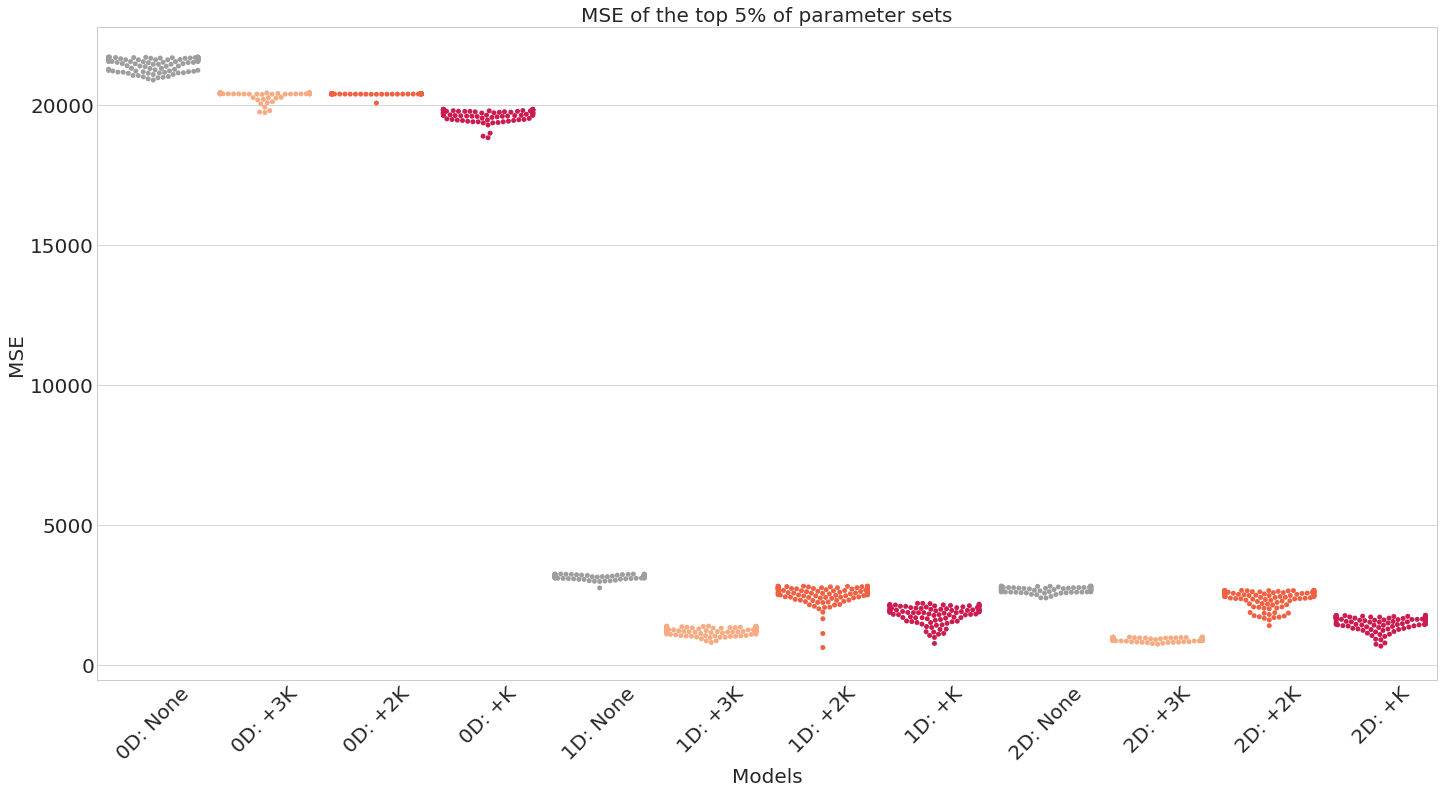

In [157]:
plt.rcParams['figure.figsize'] = [24.0, 12.0]
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [last_mses_an_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D, 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['0D: None', '0D: +3K', '0D: +2K', '0D: +K',
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'mses_all')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mses_all.png",dpi=300)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


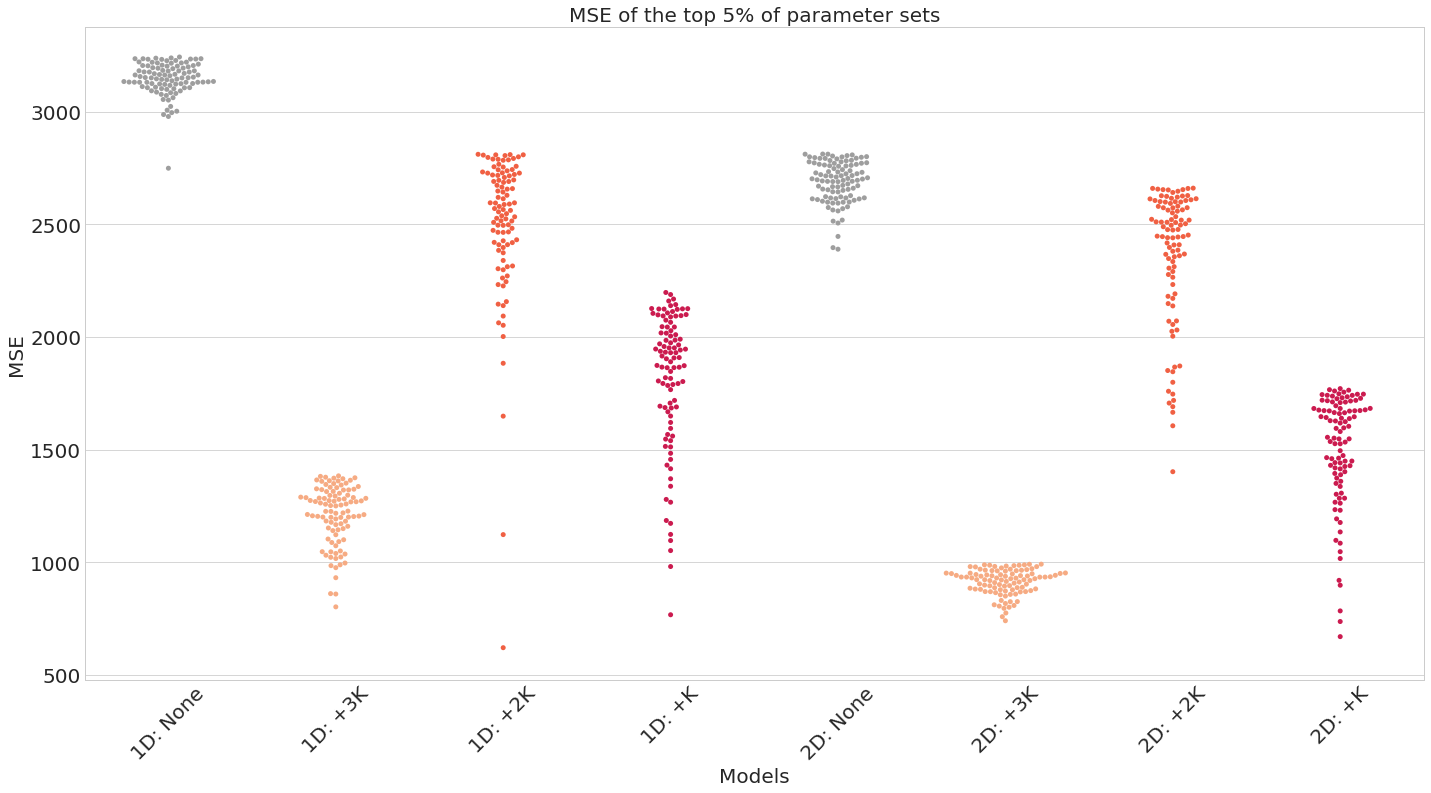

In [132]:
# plt.rcParams['figure.figsize'] = [24.0, 12.0]
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()
# rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [ 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses([
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'181024/mses_delay')

# Extra

## Plot MAP2K

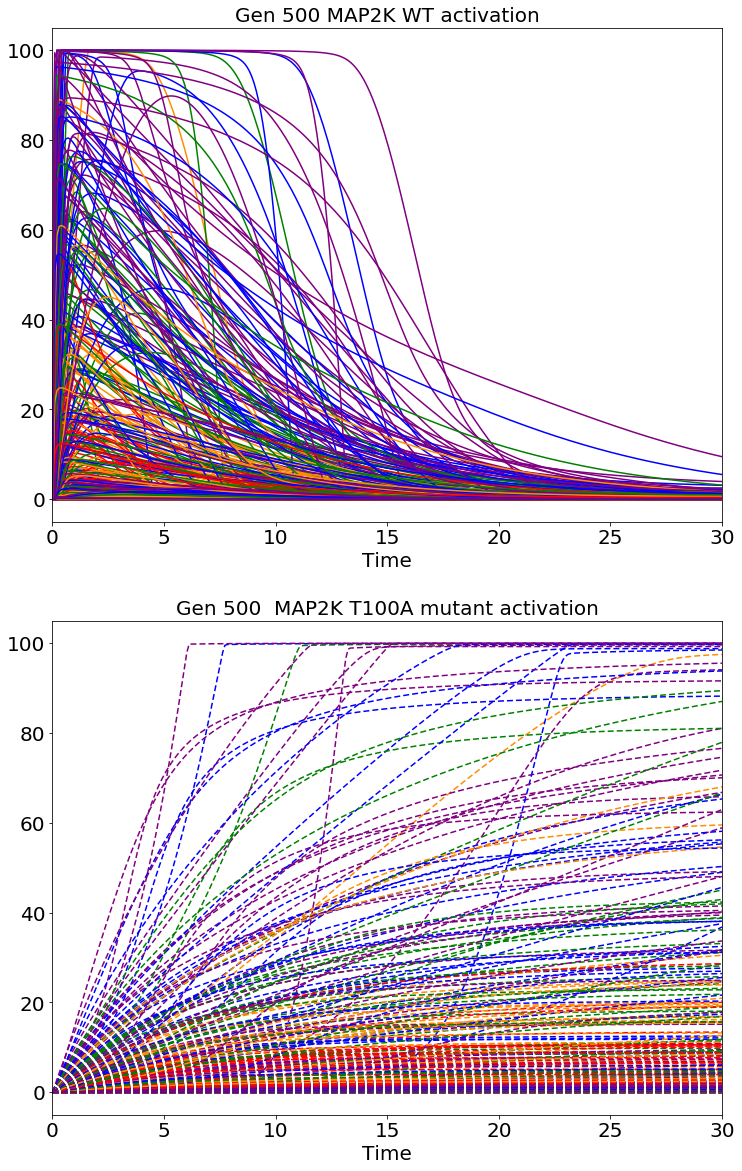

In [324]:
dt = 0.1
steps = 300
time = np.linspace(0,dt*steps,steps)

#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,20))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP2K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]/params_constants[1]*100
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,30)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP2K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]/params_constants[1]*100
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,30)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot MAP3K

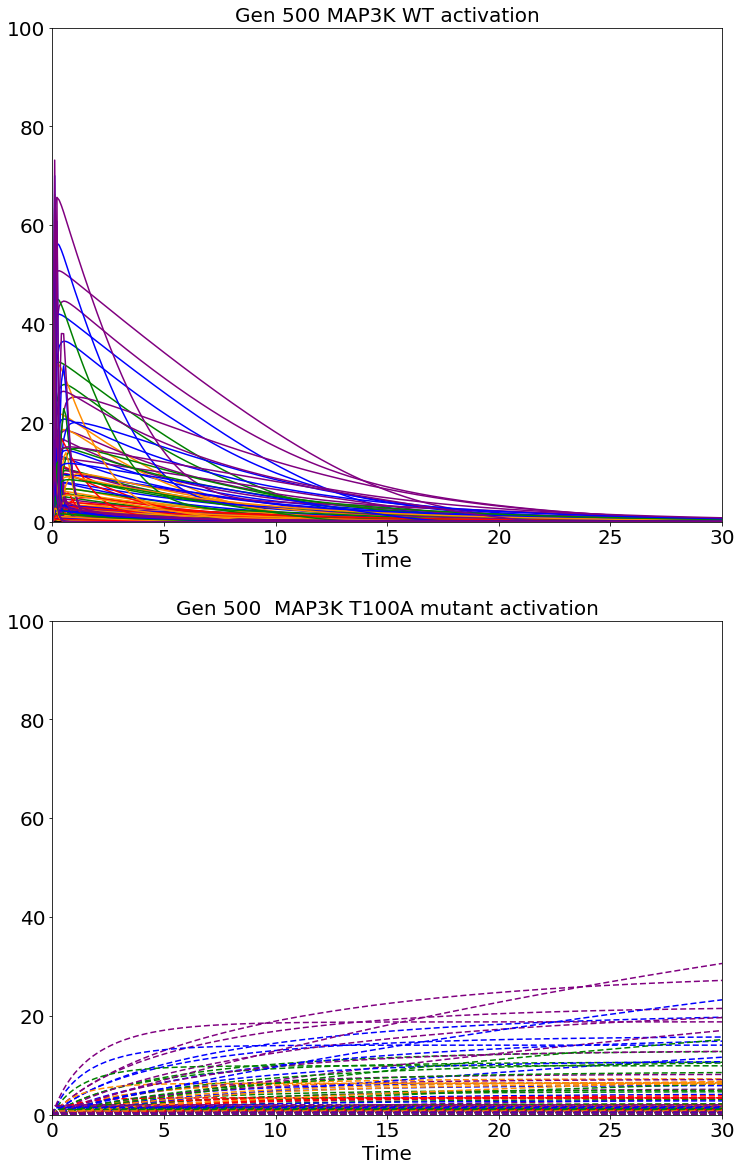

In [325]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,20))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP3K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
# color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]/params_constants[0]*100
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,30)
        ax1.set_ylim(0,100)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP3K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]/params_constants[0]*100
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,30)
        ax2.set_ylim(0,100)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Cytosolic MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active cytosolic MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
ax1.set_ylim([0,100])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active cytosolic MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Nuclear MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' nuclear MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  nuclear MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot X

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active X'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active X'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Visualize individual param sets

In [ ]:
color_palette = sns.color_palette("rocket", 6)[::-1]

for i, params in enumerate(top_params):
#     beta_1, beta_2, alpha, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, kn, kc = params
#     params = beta_1, beta_2, 0, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, 0, kc
    #plot real data:
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        plt.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
        plt.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
        data = odeint(b0_D, initals, time, args=(params_constants[:-1]+[signal], params))
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' WT active', color=color_palette[idx])
#         plt.plot(time, data[:,4], dashes=[2, 2], label=str(signal)+' X')
        data = simulate_t100a_experiment(initals, params_constants[:-1]+[signal], params, time)
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' T100A active', dashes= [4,2], color=color_palette[idx])
#         plt.plot(time, data[:,3], label=str(signal)+' MAPKn')
    plt.title(f'Param set {i}')
    plt.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.ylim(0,100)
    plt.show()

## Compare parameter correlations

In [ ]:
top_params_T = np.asarray(top_params).T

# idx = 18
for idx in range(len(top_params_T)):
    for i in range(len(top_params_T)):
        corr = np.corrcoef(top_params_T[idx],top_params_T[i])[0][1]
        if abs(corr) > 0.6 and abs(corr) < 0.999:
            print(labelnames[idx] + ' vs. '+ labelnames[i])
            print(np.corrcoef(top_params_T[idx],top_params_T[i])[0][1])
#     fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
#     ax1.scatter(top_params_T[idx],top_params_T[i])
#     ax1.set_ylabel(labelnames[i])
#     ax1.set_title('Raw')
#     ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
#     ax2.set_xscale('log')
#     ax2.set_title('Log')
#     plt.show()


In [ ]:
idx = 0
for i in range(len(top_params_T)):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
    ax1.scatter(top_params_T[idx],top_params_T[i])
    ax1.set_ylabel(labelnames[i])
    ax1.set_title('Raw')
    ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
    ax2.set_xscale('log')
    ax2.set_title('Log')
    plt.show()


# Model investigation

In [ ]:
top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]

In [ ]:
print(top_params[0])
beta_0,    k0, k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t = top_params[0]
top_params[0] = beta_0,    k0, k1, .1, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t
for idx, sig in enumerate(params_constants[-1]):
    params_c = params_constants[:-1]+[sig]
    data = simulate_wt_experiment(initals, params_c, top_params[0], time)
    active = (data[:,2] + data[:,3])/params_constants[2]*100
    plt.plot(time, active, color=color_palette[idx])
    plt.ylim(0,100)

# Results Notes 